In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

## Poject: <a style="color:purple;">**Macroeconomic Analysis of the US Economy**</a> - part 2

#### Author: @**engine**, Date: November 2024

### Abstract:
TODO

### 1. **Defining the problem and main assumptions**

In the **first part** of this study, looking at the distribution of funds from the US budget, we did not see good prospects in the future. It is not invested in the development of the USA, but in the wars, their consequences and the interest on the loans taken.
The share of interest payments on borrowed loans is also very large. The almost direct linear dependence of the expansion of the economy on inflation (printing money) and borrowing was also shown. The latter, since the dollar is a world currency, means printing money again. As a result of all that has been said so far, we can safely summarize that the American economy is addicted to printing new money. The trade balance is strongly negative with a worsening trend. Science is not a priority. If for some reason the printing of new money stops and/or the dollars of the world go "home" to the USA, we are waiting for "Great Depression - 2".

From here, we can ask ourselves the following question: <a style="color:purple;">**Can we use ML to predict approximately when the US economy will go into recession?**</a><br>The **second part** of the present study will be based on the answer to this question.

There are **2 main theoretical assumptions** at play:<br>
1. U.S. recessions exhibit markers / early warning signs.<br>
There exist plenty of recession “signals” in the form of individual economic or market data series. While individually, these signals have limited information value, they may become more useful when combined together.
2. Future recessions will be similar to historical recessions.<br>
This assumption is a lot more shaky, but can be mitigated by choosing features that maintain significance despite the changing economic landscape. For example, focusing on manufacturing data may have been relevant historically, but may be less relevant going forward as the world goes digital.

**What Have Others Tried?**

 - **Guggenheim Partners** has 2 recession related indicators: a Recession Probability Model and a Recession Dashboard, both driven by a combination of economic and market indicators. They try to predict recession probabilities across 3 different time frames.
 - **New York FED** predicts recession probabilities. Its limitations are that it only provides a 12-month forecast, and it only relies on 1 variable (the spread between the 10-year and 3-month Treasury rates).
 - **Rabobank** has a recession probability model, but it is also only based on 1 variable (the spread between the 10-year and 1-year Treasury rates), and only covers one time period (17-months).
 - **Wells Fargo Economics** has a few recession probability models that use a combination of economic and market data. However, they only limit their forecast to a 6-month horizon. [1]

**Model Benchmarking / Comparison**

Ideally, I would compare my model performance to each of the alternatives above. Currently, I cannot do this for the following reasons:

 - **Guggenheim model**: Model performance data is not publicly released.
 - **New York FED** model: Upon closer inspection, their model is built to answer the question “what is the probability that the U.S. will be in a recession X months from now?”, whereas my model is built to answer the question “what is the probability that the U.S. will be in a recession within the next X months?”.
 - **Rabobank model**: The same reason. Additionally, the Rabobank model covers a 17-month time period, whereas my model covers 6-month and 12-month time periods.
 - **Wells Fargo Economics** model: Model performance data is not publicly released.

### 2. **Preparing the Data**

#### 2.1 Criteria according to which the data for the present study were collected.

Some things I had to consider when getting the data:

 - **Economic data are released at different frequencies** (weekly, monthly, quarterly, etc.). To time-match data points, I settled for only using data that could be sampled monthly. As a result, all predictions must be conducted at a monthly frequency. This means that GDP data, as it comes out on a quarterly basis, will be approximated to a monthly basis.
 - **Varying data history lengths**. Some data has been released since 1919, while other data only goes back a few years. This means I had to exclude potentially useful data that just didn’t have enough history.
 - **Speaking of history**, I needed enough data to encompass as many recessions as I could. In the end, the full data set included 8 recessions since 1966.
 - **Economic data gets revised often**. FRED (Federal Reserve Economic Data) does not provide the original figures. It only provides the revised figures (no matter how far after-the-fact those revisions are made).
 - **Rare-event prediction**: Recessions are rare.
 - **Small data set**: Because I am using economic data (which is updated at a frequency of months or quarters), I will only have a few hundred data points to work with.
 - For practical reasons, I used mostly **public domain data** available through **[FRED](https://fred.stlouisfed.org/)** and **[Stooq](https://stooq.com/)**. I did not use potentially useful data that is stuck behind a paywall, such as [The Conference Board Leading Economic Index](https://www.conference-board.org/topics/us-leading-indicators).

#### 2.2 Feature Selection.

Some project-specific considerations for feature selection: <br> 
- **Curse of Dimensionality**. Since the data set is so small (only a few hundred data points), one cannot include too many features in the final model. Otherwise, the model will fail to generalize to out-of-sample data. Therefore, features must be carefully chosen for the incremental value that each feature provides.
- **Domain knowledge is key**. Since the underlying process is a complex time series, automated feature selection methods have a high risk of over-fitting to prior data. Therefore, feature selection must be guided by a solid understanding of economic fundamentals.

**A general outline for feature-selection process**:

 - Define the data set on which to perform exploratory data analysis (Jan 1966 to Apr 1968, May 1968 to Sep 1977, Oct 1977 to Mar 1972) to ensure no intersection with cross-validation periods.
 - Organize potential features into buckets, based on economic / theoretical characteristics (domain knowledge).
 - Plot pairwise correlations between each individual feature and each output type (6-month ahead, 12-month ahead) using the exploratory data set only (no peeking ahead!).
 - Move sequentially from feature bucket to feature bucket, such that each bucket has at least one feature in the final data set. For tie-breakers, pick features that have low correlations to features that have already been “accepted” into the final data set.

Here is how it went:

First, a sneak peek at the final feature list. Note that only 7 features made it to the final list:

<table>
  <caption>
    Feature table
  </caption>
  <thead style="background-color: purple; text-align: left">
    <tr>
      <th scope="col" style="color: white">Type</th>
      <th scope="col" style="color: white">Base indicator</th>
      <th scope="col" style="color: white">Index</th>     
      <th scope="col" style="color: white">Modification</th>
    </tr>
  </thead>
  <tbody style="text-align: left">
    </tr>
      <tr>
      <th scope="row">Market</th>
      <td>Real Gross Domestic Product</td>
      <td>GDPC1</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Market</th>
      <td>Personal Consumption Expenditures</td>
      <td>PCEPI</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Commodity market</th>
      <td>Industrial Production Index</td>
      <td>INDPRO</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Stock Market</th>
      <td>S&P 500 Index</td>
      <td>SP500</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Bond Market</th>
      <td>10 year Treasury Bond</td>
      <td>TR10</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Bond Market</th>
      <td>Slope of the yield curve</td>
      <td>T10YFF</td>
      <td>12 month change</td>
    <tr>
      <th scope="row">Unemployment</th>
      <td>Monthly Unemployment Rate</td>
      <td>UNRATE</td>
      <td>12 month change</td>
    </tr>
  </tbody></table>

1. <a style="color:purple;">**Real Gross Domestic Product**:</a><br>

The inclusion of Real Gross Domestic Product (GDP) in the ML model for predicting recessions in the US economy can be justified in several ways:<br>
**Economic Indicator:** GDP is one of the most important indicators of the health of the economy and is widely used to assess economic development. Changes in the value of GDP can be indicative of changes in economic activity and warn of an impending recession.<br>
**Correlation with other factors:** GDP is correlated with many other economic indicators such as unemployment, inflation, investment and consumption. Including GDP in the model can help capture these complex interactions and improve the predictive power of the model.<br>
**Long-Term Trends:** Research shows that changes in the value of GDP can be harbingers of future economic recessions. Including this key indicator in the model can help detect long-term trends and cycles in the economy.<br>
**Financial Market:** Investors often use GDP data to make investment decisions. GDP forecasts based on the ML model can be useful for investors in assessing risk and profit opportunities.

2. <a style="color:purple;">**Industrial Production Index**:</a><br>

The Industrial Production Index measures the output of the industrial sector, which is a key driver of economic growth. Changes in industrial production can signal shifts in overall economic activity and provide early warnings of potential recessions.

3. <a style="color:purple;">**Monthly Unemployment Rate**:</a><br>

The monthly unemployment rate is a key indicator of labor market conditions and can provide insights into the overall health of the economy. Rising unemployment rates can signal economic weakness and potential recessions.

4. <a style="color:purple;">**S&P 500 Index**:</a><br>

The S&P 500 Index is a widely followed benchmark for the performance of the US stock market. Changes in the S&P 500 Index can reflect investor sentiment and expectations for future economic growth.

5. <a style="color:purple;">**US 10-year Treasury Bond**:</a><br>

The US 10-year Treasury bond yield is often seen as a safe-haven asset and can provide insights into investor expectations for future economic conditions. Changes in the yield curve can signal shifts in market sentiment and potential economic risks.

6. <a style="color:purple;">**Slope of the yield curve**:</a><br>

The slope of the yield curve, particularly the difference between short-term and long-term interest rates, can provide insights into market expectations for future economic conditions. Inverted yield curves, where short-term rates are higher than long-term rates, have historically been a reliable predictor of recessions.

7. <a style="color:purple;">**Personal Consumption Expenditures**:</a><br>

Personal consumption expenditures are a key component of GDP and can provide insights into consumer spending patterns and overall economic activity. Changes in personal consumption expenditures can signal shifts in consumer confidence and potential risks for the economy.

In principle, <a style="color:purple;">more features can be included in the model, but there is no time continuous data for them since **January 1962**</a>. Which would improve the model but reduce the range of data used to 1972 or later.

#### 2.3 Data collection.

1. **<a style="color:purple;">"Real Gross Domestic Product</a>** (GDPC1):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GDPC1)** we download information for the period of our study: **Real Gross Domestic Product (GDPC1)**. [2]
Units: <a style="color:purple;">**Billions of Dollars**</a>, Seasonally Adjusted Annual Rate.
Frequency: **Quarterly**.


In [13]:
# ===> No data yet until September 2024. <===

gdp = pd.read_csv('data/GDPC1.csv') # Read the CSV file
gdp.columns = ["date", "gdp"]
gdp['gdp'] = gdp['gdp'] * 1_000_000_000 # convert to dollars
gdp
# __________ DataFrame (DF) with real data! __________

,date,gdp
0,1962-01-01,3.758147e+12
1,1962-04-01,3.792149e+12
2,1962-07-01,3.838776e+12
3,1962-10-01,3.851421e+12
4,1963-01-01,3.893482e+12
...,...,...
245,2023-04-01,2.222535e+13
246,2023-07-01,2.249069e+13
247,2023-10-01,2.267926e+13
248,2024-01-01,2.275875e+13


Data for the period under study are given by quartals, not by months. To obtain the requested data from **January 2022** to **October 2024**, we use a **linear approximation**.

          date           gdp
0   1962-01-01  3.758147e+12
1   1962-02-01  3.769406e+12
2   1962-03-01  3.780664e+12
3   1962-04-01  3.791923e+12
4   1962-05-01  3.807278e+12
..         ...           ...
748 2024-05-01  2.273296e+13
749 2024-06-01  2.275982e+13
750 2024-07-01  2.281279e+13
751 2024-08-01  2.286576e+13
752 2024-09-01  2.291874e+13

[753 rows x 2 columns]


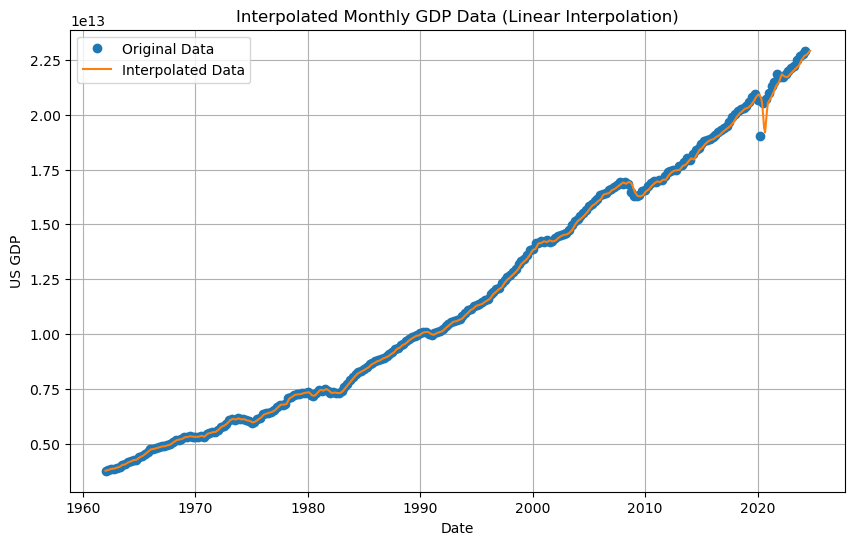

In [15]:
gdp_df = gdp.copy()

# We make sure that the 'date' column is of type datetime.
gdp_df['date'] = pd.to_datetime(gdp_df['date'])

# Generate monthly dates.
monthly_dates = pd.date_range(start='1962-01-01', end='2024-09-01', freq='MS')

# Linear interpolation. We use numpy.interp for linear interpolation.
x = np.arange(len(gdp_df))
y = gdp_df['gdp'].values
x_new = np.linspace(x.min(), x.max(), len(monthly_dates))

y_new = np.interp(x_new, x, y)

# Create a new DataFrame with the interpolated data.
interpolated_gdp = pd.DataFrame({
    'date': monthly_dates,
    'gdp': y_new
})

# We make sure that the 'date' column is of type datetime.
interpolated_gdp['date'] = pd.to_datetime(interpolated_gdp['date'])

# __________ DataFrame (DF) with final data! __________
print(interpolated_gdp)

# Preview the results.
plt.figure(figsize=(10, 6))
plt.plot(gdp_df['date'], gdp_df['gdp'], 'o', label='Original Data')
plt.plot(interpolated_gdp['date'], interpolated_gdp['gdp'], '-', label='Interpolated Data')
plt.xlabel('Date')
plt.ylabel('US GDP')
plt.title('Interpolated Monthly GDP Data (Linear Interpolation)')
plt.legend()
plt.grid(True)
plt.show()

We will use statistical methods to detect outliers, for example the interquartile range (IQR) method, which is robust to outliers, or the standard deviation.

In [17]:
# Data filtering after 2020.
gdp_df_after_2020 = gdp_df[gdp_df['date'] >= '2020-01-01']

# Determination of IQR (interquartile range).
Q1 = gdp_df_after_2020['gdp'].quantile(0.25)
Q3 = gdp_df_after_2020['gdp'].quantile(0.75)
IQR = Q3 - Q1

# Defining the limits for detecting outliers.
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identification on outliers.
outliers = gdp_df_after_2020[(gdp_df_after_2020['gdp'] < lower_bound) | (gdp_df_after_2020['gdp'] > upper_bound)]

# Show outliers.
print("Outliers after 2020:")
print(outliers)

Outliers after 2020:
          date           gdp
233 2020-04-01  1.903483e+13


The date **2020-04-01** coincides with the period of COVID-19 and especially with that part of it, the forced closure of businesses was the most unexpected. Therefore, the strong deviation of the GDP curve **cannot be considered an outlier, which for the purpose of our study should be corrected** in some way.

In [19]:
del gdp
del gdp_df
interpolated_gdp['gdp'].describe().T

count    7.530000e+02
mean     1.176313e+13
std      5.557101e+12
min      3.758147e+12
25%      6.774491e+12
50%      1.060706e+13
75%      1.669196e+13
max      2.291874e+13
Name: gdp, dtype: float64

2. **<a style="color:purple;">Personal Consumption Expenditures</a>** (PCEPI)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PCEPI)** we download information for the period of our study: **Personal Consumption Expenditures (PCEPI)** [3], Seasonally Adjusted Annual Rate. Frequency: **Monthly**.

In [22]:
# ===> No data yet until September 2024. <===

pcepi = pd.read_csv('data/PCEPI.csv') # Read the CSV file
pcepi.columns = ["date", "pcepi"]
pcepi
# __________ DataFrame (DF) with final data! __________

,date,pcepi
0,1962-01-01,15.776
1,1962-02-01,15.818
2,1962-03-01,15.839
3,1962-04-01,15.857
4,1962-05-01,15.867
...,...,...
745,2024-02-01,122.367
746,2024-03-01,122.782
747,2024-04-01,123.109
748,2024-05-01,123.146


In [23]:
pcepi.describe().T

,count,mean,std,min,25%,50%,75%,max
pcepi,750.0,61.595807,31.136916,15.776,30.45675,64.647,88.758,123.243


3. **<a style="color:purple;">Industrial Production Index</a>** (INDPRO)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/INDPRO)** we download information for the period of our study: **Industrial Production Index (INDPRO)** [4], Seasonally Adjusted. Frequency: **Monthly**.

In [25]:
# ===> No data yet until September 2024. <===

indpro = pd.read_csv('data/INDPRO.csv') # Read the CSV file
indpro.columns = ["date", "indpro"]
indpro
# __________ DataFrame (DF) with final data! __________

,date,indpro
0,1962-01-01,24.6496
1,1962-02-01,25.0529
2,1962-03-01,25.1873
3,1962-04-01,25.2410
4,1962-05-01,25.2141
...,...,...
746,2024-03-01,102.5001
747,2024-04-01,102.4955
748,2024-05-01,103.2734
749,2024-06-01,103.5494


In [26]:
indpro.describe().T

,count,mean,std,min,25%,50%,75%,max
indpro,751.0,69.589985,25.562176,24.6496,47.4947,64.9262,95.9104,104.1038


4. **<a style="color:purple;">S&P 500 Index</a>** (SP500)

From this site **[Stooq](https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m)** we download information for the period of our study: **S&P 500 Index (SP500)** [5], Frequency: **Monthly**. This is the only publicly available data for the S&P 500 Index, which contains information all the way back to 1962!

In [28]:
# ===> No data yet until September 2024. <===

sp = pd.read_csv('data/SP500.csv') # Read the CSV file
sp.head()

,Date,Open,High,Low,Close,Volume
0,1/31/1962,71.55,71.96,67.55,68.84,44883332
1,2/28/1962,68.84,71.13,68.56,69.96,36738890
2,3/31/1962,69.96,71.44,69.16,69.55,38022223
3,4/30/1962,69.55,69.82,64.95,65.24,36244446
4,5/31/1962,65.24,66.93,53.13,59.63,61683334


In [29]:
# Keep only the required columns.
keep_col = ['Date', 'Close']
sp500 = sp[keep_col]
del sp

# Renaming columns.
sp500.columns = ['date', 'sp500']

# __________ DataFrame (DF) with final data! __________
sp500

,date,sp500
0,1/31/1962,68.84
1,2/28/1962,69.96
2,3/31/1962,69.55
3,4/30/1962,65.24
4,5/31/1962,59.63
...,...,...
747,4/30/2024,5035.69
748,5/31/2024,5277.51
749,6/30/2024,5460.48
750,7/31/2024,5522.30


In [30]:
sp500.describe().T

,count,mean,std,min,25%,50%,75%,max
sp500,752.0,975.956077,1170.838974,54.75,104.175,445.02,1329.1975,5591.96


5. **<a style="color:purple;">10 year Treasury Bond</a>** (TR10)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/dgs10)** we download information for the period of our study: **10 year Treasury Bond** [6], Percent, Not Seasonally Adjusted Frequency: **Daily**.

In [32]:
# ===> No data yet until September 2024. <===

df = pd.read_csv('data/DGS10.csv') # Read the CSV file
df.columns = ["date", "tr10"]
df # __________ DataFrame (DF) with real data! __________

,date,tr10
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-08,4.03
...,...,...
16342,2024-08-22,3.86
16343,2024-08-23,3.81
16344,2024-08-26,3.82
16345,2024-08-27,3.83


In [33]:
# Replace '.' with NaN and convert column 'tr10' to numeric type.
df['tr10'] = pd.to_numeric(df['tr10'], errors='coerce')

# Group by month and calculate the arithmetic mean for each month.
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
monthly_avg = df.resample('MS').mean()

# Create a new dataframe with the first number of the month and the arithmetic mean.
tr10 = monthly_avg.reset_index()
del df

# __________ DataFrame (DF) with final data! __________
tr10

,date,tr10
0,1962-01-01,4.083182
1,1962-02-01,4.039444
2,1962-03-01,3.930455
3,1962-04-01,3.843000
4,1962-05-01,3.873636
...,...,...
747,2024-04-01,4.539091
748,2024-05-01,4.482273
749,2024-06-01,4.305263
750,2024-07-01,4.248636


In [34]:
tr10['tr10'].describe().T

count    752.000000
mean       5.856778
std        2.962996
min        0.623636
25%        3.869750
50%        5.578673
75%        7.576274
max       15.323810
Name: tr10, dtype: float64

6. **<a style="color:purple;">Slope of the yield curve</a>** (UNRATE):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we download information for the period of our study: **Slope of the yield curve (TUNRATE)**. [7]
Units: Percent, Seasonally Adjusted, Frequency: **Monthly**.

In [36]:
# ===> No data yet until September 2024. <===

data = pd.read_csv('data/T10YFF.csv') # Read the CSV file
data.columns = ["date", "t10yff"]
data
# __________ DataFrame (DF) with real data! __________

,date,t10yff
0,1/2/1962,1.31
1,1/3/1962,1.53
2,1/4/1962,1.24
3,1/5/1962,1.52
4,1/8/1962,2.03
...,...,...
16342,8/22/2024,-1.47
16343,8/23/2024,-1.52
16344,8/26/2024,-1.51
16345,8/27/2024,-1.5


In [37]:
# Replace '.' with NaN and convert column 't10yff' to numeric type.
data['t10yff'] = pd.to_numeric(data['t10yff'], errors='coerce')

# Group by month and calculate the arithmetic mean for each month.
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
monthly_avg = data.resample('MS').mean()

# Create a new dataframe with the first number of the month and the arithmetic mean.
t10yff = monthly_avg.reset_index()
del data

# __________ DataFrame (DF) with final data! __________
t10yff

,date,t10yff
0,1962-01-01,2.060455
1,1962-02-01,1.650556
2,1962-03-01,1.078182
3,1962-04-01,1.043000
4,1962-05-01,1.441818
...,...,...
747,2024-04-01,-0.790909
748,2024-05-01,-0.847727
749,2024-06-01,-1.024737
750,2024-07-01,-1.081364


In [38]:
t10yff['t10yff'].describe().T

count    752.000000
mean       0.986966
std        1.617967
min       -6.291905
25%        0.122619
50%        1.160208
75%        2.181648
max        3.803636
Name: t10yff, dtype: float64

7. **<a style="color:purple;">Monthly Unemployment Rate</a>** (UNRATE):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we download information for the period of our study: **Monthly Unemployment Rate (UNRATE)**. [8]
Units: Percent, Not Seasonally Adjusted, Frequency: **Monthly**.

In [40]:
# ===> No data yet until September 2024. <===

unrate = pd.read_csv('data/UNRATE.csv') # Read the CSV file
unrate.columns = ["date", "unrate"]
unrate
# __________ DataFrame (DF) with final data! __________

,date,unrate
0,1962-01-01,5.8
1,1962-02-01,5.5
2,1962-03-01,5.6
3,1962-04-01,5.6
4,1962-05-01,5.5
...,...,...
746,2024-03-01,3.8
747,2024-04-01,3.9
748,2024-05-01,4.0
749,2024-06-01,4.1


In [41]:
unrate.describe().T

,count,mean,std,min,25%,50%,75%,max
unrate,751.0,5.891611,1.718758,3.4,4.6,5.6,7.0,14.8


### 5. **Conclusions**

1. **TODO**

### Resources:
1. **Recession Prediction using Machine Learning** https://towardsdatascience.com/recession-prediction-using-machine-learning-de6eee16ca94
2. **Real Gross Domestic Product** https://fred.stlouisfed.org/series/GDPC1
3. **Personal Consumption Expenditures** https://fred.stlouisfed.org/series/PCEPI
4. **Industrial Production: Total Index** https://fred.stlouisfed.org/series/INDPRO
5. **Historical data: S&P 500 - U.S.** https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m
6. **Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity** https://fred.stlouisfed.org/series/dgs10
7. **10-Year Treasury Constant Maturity Minus Federal Funds Rate** https://fred.stlouisfed.org/series/T10YFF
8. **Monthly Unemployment Rate** https://fred.stlouisfed.org/series/UNRATE
9. **...**
10. **...**
11. **...**
12. **...**
13. **...**
14. **...**